In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import interpolate,stats
import openpyxl

## Define functions describing single or bi-exponential decay of normalized iFRAP intensity

In [2]:
#single exponential function
def singlexp(t, k1):
    return np.exp(-k1*t)
# bi-exponential function
def biexp(t, f1, k1, k2):
    return f1*np.exp(-k1*t)+(1-f1)*np.exp(-k2*t)

## Every dataset has slightly different x values (timestamps). To compare fits, generate a new dataframe with interpolated values

In [3]:
z=range(91) # represents minutes 0–90 in each experiment

def interpolate_df(df, z):
    """interpolate datapoints"""
    f=interpolate.interp1d(df.index, df)
    if df.index[-1]<z[-1]: # if less data points were acquired in a subset of samples
        z=range(int(np.floor(df.index[-1])))
    dfnew=pd.Series(f(z), index=z)
    return dfnew

## Plot and save the mean FRAP, fit and residual values

In [4]:
def plot_frap(gene):
    """Plot a figure with 2 axes containing FRAP and curve fitted data"""
    fig, ax = plt.subplots(1,2,figsize=(10,4))

    ax[0].set_title('SMC3-LAP '+gene.upper()+' RNAi (fit)')
    ax[0].errorbar(frap.index, np.mean(frap,axis=1),yerr=stats.sem(frap, axis=1, nan_policy='omit'),
                   linewidth=2, capsize=2,capthick=1,color='k',label='iFRAP data')
    ax[0].errorbar(frap.index, np.mean(singlexp_curves,axis=1),
                   yerr=stats.sem(singlexp_curves,axis=1, nan_policy='omit'),
                   linewidth=2, capsize=2,capthick=1, color='m', label='fit (single exponential)')
    ax[0].errorbar(frap.index, np.mean(biexp_curves,axis=1),
                   yerr=stats.sem(biexp_curves,axis=1, nan_policy='omit'),
                   linewidth=2, capsize=2,capthick=1, color='limegreen', label='fit (bi-exponential)')
    ax[0].set_xlabel("time (min)")
    ax[0].set_ylabel("normalized intensity difference")
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].set_ylim(0,1)
    ax[0].set_xlim(0,90)
    ax[0].legend(loc=1, bbox_to_anchor=(1,0.95), frameon=False)

    ax[1].set_title('SMC3-LAP '+gene.upper()+' RNAi (residuals)')
    ax[1].errorbar(frap.index, np.mean(singlexp_residuals,axis=1),
                   yerr=stats.sem(singlexp_residuals, axis=1, nan_policy='omit'),
                   color='m', label=f'single exponential, R\N{SUPERSCRIPT TWO} = {round(rsquared[0],3)}')
    ax[1].errorbar(frap.index, np.mean(biexp_residuals,axis=1),
                   yerr=stats.sem(biexp_residuals, axis=1, nan_policy='omit'),
                   color='limegreen', label=f'bi-exponential, R\N{SUPERSCRIPT TWO} = {round(rsquared[1],3)}')
    ax[1].set_xlabel("time (min)")
    ax[1].set_ylabel("difference (data - fit)")
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['bottom'].set_linestyle('dashed')
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['bottom'].set_position(('data', 0))
    ax[1].set_ylim([-.3,.3])
    ax[1].set_xlim(0,90)
    ax[1].legend(loc=1, bbox_to_anchor=(1,0.95), frameon=False)

    fig.savefig(os.path.join(folder,gene+"_FRAP.png"), bbox_inches='tight', dpi=300)
    plt.show()

## Provide a directory containing folders for each genotpye, with each folder containing txt files for each cell with 2 columns: column 1 provides time information (seconds), column 2 provides normalized intensities

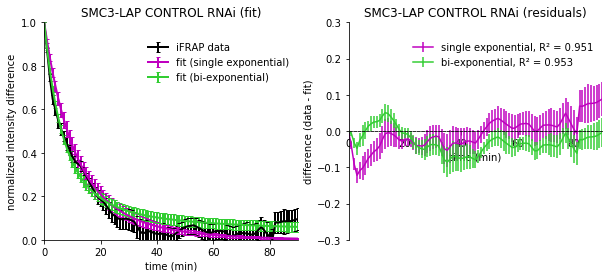

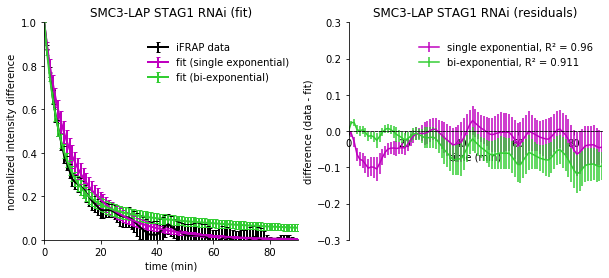

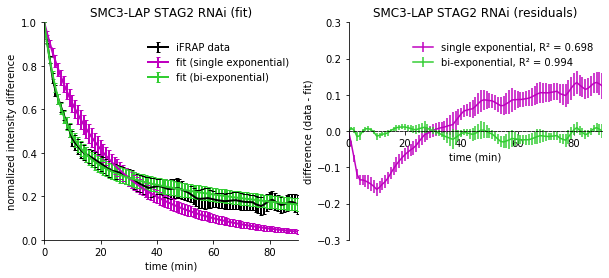

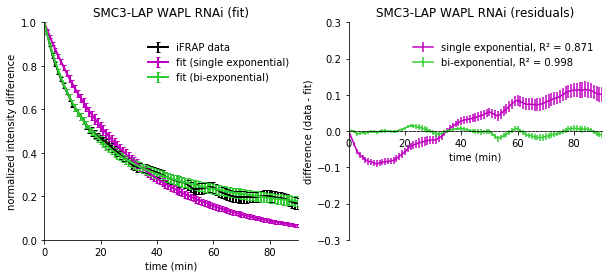

In [5]:
folder='/FRAP/txt files'
genes=['control','stag1','stag2','wapl']

for gene in genes:
    frap={} # a frap value dictionary for each gene
    singlexp_curves={}
    singlexp_residuals={}
    singlexp_residencetimes={} # dissociation constant with single exponential function
    biexp_curves={}
    biexp_residuals={}
    biexp_parameters={}
    rsquared=[]
    
    counter=1
    for file in sorted(os.listdir(os.path.join(folder,gene))):
        if file.endswith('.txt'):
            fname=gene+'_'+str(counter)
            df=pd.read_csv(os.path.join(folder,gene,file), sep='\t', header=None, dtype=float, 
                           names=['time','data'])
            df=df.set_index(df.time/60).data # adjust seconds to minutes
            df=interpolate_df(df, z)
            frap[fname]=df
            
            # fit curves with predetermined bounds and initial values
            spar,scov=curve_fit(singlexp, df.index, df, p0=4.98e-2, bounds=(2.7e-2, 0.3))
            bipar,bicov=curve_fit(biexp, df.index, df, p0=(0.4, 4.98e-2, 2.52e-3), bounds=((0, 4.86e-2, 1.8e-3),(1.0, 0.3, 4.2e-2)))
            
            singlexp_residencetimes[fname]=round(1/spar[0],2)
            singlexp_curves[fname]=pd.Series(singlexp(z,spar[0]))
            singlexp_residuals[fname]=df.dropna()-singlexp_curves[fname]
            
            biexp_parameters[fname]=[round(100*(1-bipar[0]),2),round(1/bipar[1],2),round(1/bipar[2]/60,2)]
            biexp_curves[fname]=pd.Series(biexp(z,*bipar))
            biexp_residuals[fname]=df-biexp_curves[fname]

            counter+=1
    
    # combine data for each gene and save to folder
    frap=pd.DataFrame(frap)
    frap.index.name='time [min]'
    frap.to_excel(os.path.join(folder,gene+"_frap.xlsx"))
    
    singlexp_residencetimes=pd.Series(singlexp_residencetimes,name='residence time [min]')
    singlexp_residencetimes.to_excel(os.path.join(folder,gene+"_singlexp_restimes.xlsx"))
    
    biexp_parameters=pd.DataFrame.from_dict(biexp_parameters,orient='index',columns=
                                            ['stable fraction [%]','dynamic residence time [min]',
                                            'stable residence time [h]'])
    biexp_parameters.to_excel(os.path.join(folder,gene+"_biexp_params.xlsx"))
    
    singlexp_curves=pd.DataFrame(singlexp_curves)
    singlexp_curves.to_excel(os.path.join(folder,gene+"_singlexp_curves.xlsx"))
    singlexp_residuals=pd.DataFrame(singlexp_residuals)
    singlexp_residuals.to_excel(os.path.join(folder,gene+"_singlexp_residuals.xlsx"))

    biexp_curves=pd.DataFrame(biexp_curves)
    biexp_curves.to_excel(os.path.join(folder,gene+"_biexp_curves.xlsx"))
    biexp_residuals=pd.DataFrame(biexp_residuals)
    biexp_residuals.to_excel(os.path.join(folder,gene+"_biexp_residuals.xlsx"))
    
    ss_res_singlexp = np.sum((np.mean(frap,axis=1)-np.mean(singlexp_curves,axis=1))**2)
    ss_res_biexp = np.sum((np.mean(frap,axis=1)-np.mean(biexp_curves,axis=1))**2)
    ss_tot = np.sum((np.mean(frap,axis=1)-np.mean(np.mean(frap,axis=1)))**2)
    rsquared.append(1-ss_res_singlexp/ss_tot)
    rsquared.append(1-ss_res_biexp/ss_tot)
    r2df=pd.Series(rsquared, index=[f'single exponential R\N{SUPERSCRIPT TWO}',
                                        f'bi-exponential R\N{SUPERSCRIPT TWO}'])
    r2df.to_excel(os.path.join(folder,gene+"_rsquared.xlsx"))
    
    plot_frap(gene)
    
    

## Plot all FRAP curves on top of each other

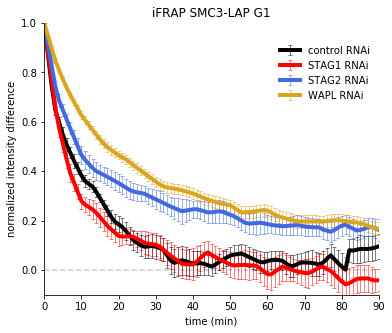

In [6]:
control_FRAP = pd.read_excel(os.path.join(folder,'control_frap.xlsx'), index_col=0)
STAG1_FRAP = pd.read_excel(os.path.join(folder,'stag1_frap.xlsx'), index_col=0)
STAG2_FRAP = pd.read_excel(os.path.join(folder,'stag2_frap.xlsx'), index_col=0)
WAPL_FRAP = pd.read_excel(os.path.join(folder,'wapl_frap.xlsx'), index_col=0)

fig=plt.figure(figsize=(6,5))
plt.errorbar(control_FRAP.index, np.mean(control_FRAP,axis=1), yerr=stats.sem(control_FRAP,axis=1,nan_policy='omit'),
             color='k',linewidth=4, capsize=2, capthick=.5,elinewidth=.5,label='control RNAi')
plt.errorbar(STAG1_FRAP.index, np.mean(STAG1_FRAP,axis=1), yerr=stats.sem(STAG1_FRAP,axis=1,nan_policy='omit'),
             color='r',linewidth=4, capsize=2, capthick=.5,elinewidth=.5,label='STAG1 RNAi')
plt.errorbar(STAG2_FRAP.index, np.mean(STAG2_FRAP,axis=1), yerr=stats.sem(STAG2_FRAP,axis=1,nan_policy='omit'),
             color='royalblue',linewidth=4, capsize=2, capthick=.5,elinewidth=.5,label='STAG2 RNAi')
plt.errorbar(WAPL_FRAP.index, np.mean(WAPL_FRAP,axis=1), yerr=stats.sem(WAPL_FRAP,axis=1,nan_policy='omit'),
             color='goldenrod',linewidth=4, capsize=2, capthick=.5,elinewidth=.5,label='WAPL RNAi')

plt.title('iFRAP SMC3-LAP G1')
plt.xlabel('time (min)')
plt.ylabel('normalized intensity difference')
plt.ylim(-.1,1)
plt.axhline(color='k',alpha=.2,ls='--')
plt.xlim(0,90)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc=1, bbox_to_anchor=(1,0.95), frameon=False)
fig.savefig(os.path.join(folder,"combined_FRAP.png"), bbox_inches='tight', dpi=300)
plt.show()


## Plot residence time for control and STAG1 RNAi FRAP (that are better described by single exponential functions)

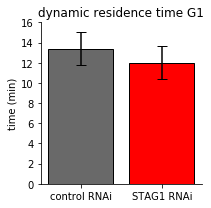

control RNAi: mean = 13.41 min ± 1.64
STAG1 RNAi: mean = 12.0 min ± 1.62


In [7]:
control_restime = pd.read_excel(os.path.join(folder,'control_singlexp_restimes.xlsx'), index_col=0)
STAG1_restime = pd.read_excel(os.path.join(folder,'stag1_singlexp_restimes.xlsx'), index_col=0)

fig=plt.figure(figsize=(3,3))
plt.bar(['control RNAi','STAG1 RNAi'],[np.mean(control_restime)[0],np.mean(STAG1_restime)[0]],
        color=['dimgray','r'],edgecolor='k',linewidth=1,
        yerr=[stats.sem(control_restime)[0],stats.sem(STAG1_restime)[0]],capsize=5)
plt.title('dynamic residence time G1')
plt.ylabel('time (min)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0,16)
plt.tight_layout()
fig.savefig(os.path.join(folder,"singlexp_residence_time.png"), bbox_inches='tight', dpi=300)
plt.show()

print(f'control RNAi: mean = {round(np.mean(control_restime)[0],2)} min ± {round(stats.sem(control_restime)[0],2)}')
print(f'STAG1 RNAi: mean = {round(np.mean(STAG1_restime)[0],2)} min ± {round(stats.sem(STAG1_restime)[0],2)}')

## Plot fraction of stable pool, stable and dynamic residence time for STAG2 and WAPL RNAi FRAP (that are better described by bi-exponential functions)

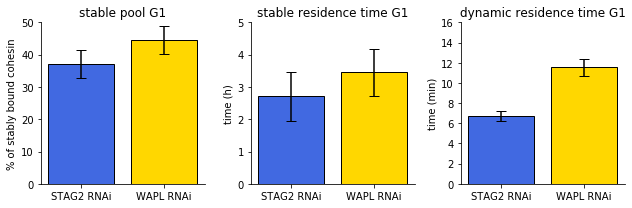

stable pool G1 percentage:
STAG2 RNAi: mean = 37.06% ± 4.35
WAPL RNAi: mean = 44.53% ± 4.41

stable residence time G1:
STAG2 RNAi: mean = 2.71 h ± 0.76
WAPL RNAi: mean = 3.46 h ± 0.72

dynamic residence time G1:
STAG2 RNAi: mean = 6.75 min ± 0.51
WAPL RNAi: mean = 11.55 min ± 0.85


In [8]:
STAG2_params = pd.read_excel(os.path.join(folder,'stag2_biexp_params.xlsx'), index_col=0)
WAPL_params = pd.read_excel(os.path.join(folder,'wapl_biexp_params.xlsx'), index_col=0)

fig, ax = plt.subplots(1,3,figsize=(9,3))
ax[0].bar(['STAG2 RNAi','WAPL RNAi'],[np.mean(STAG2_params.iloc[:,0]),np.mean(WAPL_params.iloc[:,0])],
        color=['royalblue','gold'],edgecolor='k',linewidth=1,
        yerr=[stats.sem(STAG2_params.iloc[:,0]),stats.sem(WAPL_params.iloc[:,0])],capsize=5)
ax[0].set_title('stable pool G1')
ax[0].set_ylabel('% of stably bound cohesin')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_ylim(0,50)

ax[1].bar(['STAG2 RNAi','WAPL RNAi'],[np.mean(STAG2_params.iloc[:,2]),np.mean(WAPL_params.iloc[:,2])],
          color=['royalblue','gold'],edgecolor='k',linewidth=1,
          yerr=[stats.sem(STAG2_params.iloc[:,2]),stats.sem(WAPL_params.iloc[:,2])],capsize=5)
ax[1].set_title('stable residence time G1')
ax[1].set_ylabel('time (h)')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_ylim(0,5)

ax[2].bar(['STAG2 RNAi','WAPL RNAi'],[np.mean(STAG2_params.iloc[:,1]),np.mean(WAPL_params.iloc[:,1])],
          color=['royalblue','gold'],edgecolor='k',linewidth=1,
          yerr=[stats.sem(STAG2_params.iloc[:,1]),stats.sem(WAPL_params.iloc[:,1])],capsize=5)
ax[2].set_title('dynamic residence time G1')
ax[2].set_ylabel('time (min)')
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_ylim(0,16)
fig.tight_layout()
fig.savefig(os.path.join(folder,"biexp_parameters.png"), bbox_inches='tight', dpi=300)
plt.show()

print('stable pool G1 percentage:')
print(f'STAG2 RNAi: mean = {round(np.mean(STAG2_params.iloc[:,0]),2)}% ± {round(stats.sem(STAG2_params.iloc[:,0]),2)}')
print(f'WAPL RNAi: mean = {round(np.mean(WAPL_params.iloc[:,0]),2)}% ± {round(stats.sem(WAPL_params.iloc[:,0]),2)}')

print('\nstable residence time G1:')
print(f'STAG2 RNAi: mean = {round(np.mean(STAG2_params.iloc[:,2]),2)} h ± {round(stats.sem(STAG2_params.iloc[:,2]),2)}')
print(f'WAPL RNAi: mean = {round(np.mean(WAPL_params.iloc[:,2]),2)} h ± {round(stats.sem(WAPL_params.iloc[:,2]),2)}')

print('\ndynamic residence time G1:')
print(f'STAG2 RNAi: mean = {round(np.mean(STAG2_params.iloc[:,1]),2)} min ± {round(stats.sem(STAG2_params.iloc[:,1]),2)}')
print(f'WAPL RNAi: mean = {round(np.mean(WAPL_params.iloc[:,1]),2)} min ± {round(stats.sem(WAPL_params.iloc[:,1]),2)}')
